# 1.0 Introduction

We analyze a collection of 116909 Colombia event mentions between 09/11/2016 and 06/17/2017 collected from the GDELT's Mentions (<em>[gdelt-bq:gdeltv2.eventmentions]</em>) table. The Mentions table records every mention of an event over time, along with the timestamp the article was published. This allows the progression of an event through the global media to be tracked, identifying outlets that tend to break certain kinds of events the earliest or which may break stories later but are more accurate in their reporting on those events. Combined with the 15 minute update resolution and GCAM, the Mentions table also allows the emotional reaction and resonance of an event to be assessed as it sweeps through the world’s media. We begin by identifying the most prominent media type and languages for all event mentions, then we computer the event tone and confidence distribution for all event mentions in the data set. We then identify the dominant sources with the Top 50 event mention frequencies, filter the sources relevant to the Peace Accords Matrix (PAM) implementation monitoring and verification framework, and compare their language composition as well as tone and confidence distributions.

In [35]:
# Import useful libraries
import re
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from math import isnan
from collections import Counter
from collections import OrderedDict 
from sklearn.neighbors.kde import KernelDensity
from NewspaperLanguages import translations
# Declare global options
%matplotlib inline 
pd.set_option('display.max_colwidth', -1)
plt.style.use('seaborn-whitegrid')
# Declare global variables
all_mentions = pd.read_csv('C:/Users/henry/Dropbox/GDELT/all_mentions.csv', encoding='latin-1').sort_values('EventTimeDate', ascending=1)
all_mentions.columns

Index(['GLOBALEVENTID', 'EventTimeDate', 'MentionTimeDate', 'MentionType',
       'MentionSourceName', 'MentionIdentifier', 'SentenceID',
       'Actor1CharOffset', 'Actor2CharOffset', 'ActionCharOffset', 'InRawText',
       'Confidence', 'MentionDocLen', 'MentionDocTone',
       'MentionDocTranslationInfo', 'Extras'],
      dtype='object')

# 2.0 Media Analysis

As an event is mentioned across multiple news reports, each of those mentions is recorded in the Mentions table, along with several key indicators about that mention, including the media type mentioning the event, the average "tone" of the news report mentioning the event, and the "confidence" of GDELT's algorithms in their identification of the event
from that specific news report. 

## 2.1 Mention Types

The MentionTypes field is a numerical identifier that refers to the source collection that the document originated from:

1: WEB - The document originates from the open web and the MentionIdentifier is a fully-qualified URL that can be used to access the document on the web

2: CITATIONONLY - The document originates from a broadcast, print, or other offline source in which only a textual citation is available for the document.  In this case the MentionIdentifier contains the textual citation for the document"],
3: CORE - The document originates from the CORE archive and the MentionIdentifier contains its DOI, suitable for accessing the original document through the CORE website

4: DTIC - The document originates from the DTIC archive and the MentionIdentifier contains its DOI, suitable for accessing the original document through the DTIC website

5: JSTOR - The document originates from the JSTOR archive and the MentionIdentifier contains its DOI, suitable for accessing the original document through your JSTOR subscription if your institution subscribes to it

6: NONTEXTUALSOURCE - The document originates from a textual proxy (such as closed captioning) of a non-textual information source (such as a video) available via a URL and the MentionIdentifier provides the URL of the non-textual original source.  At present, this Collection Identifier is used for processing of the closed captioning streams of the Internet Archive Television News Archive in which each broadcast is available via a URL, but the URL offers access only to the video of the broadcast and does not provide any access to the textual closed captioning used to generate the metadata.  This code is used in order to draw a distinction between URL-based textual material (Collection Identifier 1 (WEB) and URL-based non-textual material like the Television News Archive.

In [36]:
# Preprocessing: Mention Type Codes
MentionTypes = Counter(all_mentions.MentionType)

MentionTypeCodes = {1: "WEB",
                   2: "CITATIONONLY",
                   3: "CORE",
                   4: "DTIC",
                   5: "JSTOR",
                   6: "NONTEXTUALSOURCE"}

MentionTypes = OrderedDict(sorted(MentionTypes.items(), key=lambda x: x[1], reverse=True))
mention_type_labels = [MentionTypeCodes[key] for key in list(MentionTypes.keys())]
mention_type_sizes = list(MentionTypes.values())
print(MentionTypes)

OrderedDict([(1, 116787), (2, 122)])


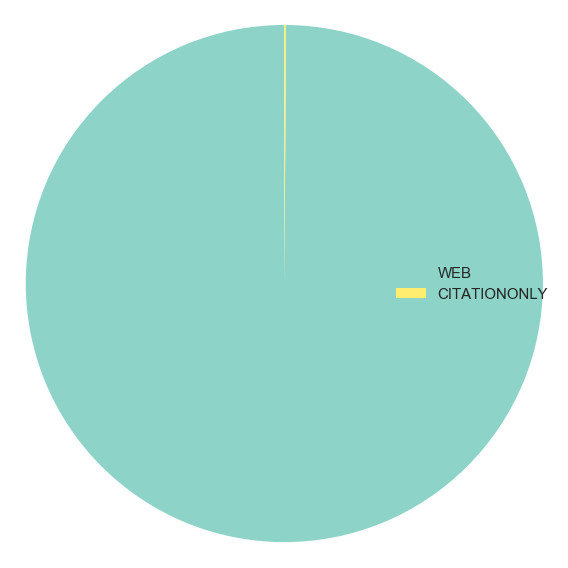

In [37]:
fig1, ax = plt.subplots(figsize=(8, 8))
patches, texts = plt.pie(mention_type_sizes, colors=cm.Set3(np.linspace(0, 1, len(mention_type_labels))), startangle=90)
plt.legend(patches, mention_type_labels, loc="right", fontsize=15)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2.2 Media Languages

GDELT provides realtime translation of the world’s news in 65 languages. The Mentions Document Translation Information (MentionDocTranslationInfo) field records the provenance information for machine-translated documents indicating the original source language and the citation of the translation system used to translate the document for processing. The field will be null for documents originally in English. The fiels will also be null for human-translated documents and provided to GDELT in English, such as BBC Monitoring materials. In the future, this field may be expanded to included information on human-translated pipelines. To analyse the language composition of the mentions documents collection, we begin by preprocessing the MentionDocTranslationInfo values to normal language names and append the clean language named to the DataFrame for further analysis.

In [38]:
# Preprocessing: Mention Document Languages
languages = []

for lang in all_mentions.MentionDocTranslationInfo:
    try:
        languages.append(translations[lang][1])
    except:
        languages.append('English')

all_mentions['Language'] = languages
languages = Counter(languages)
print(languages)
languages = OrderedDict(sorted(languages.items(), key=lambda x: x[1], reverse=True))
language_labels = [key for key in list(languages.keys())]
language_sizes = list(languages.values())

Counter({'English': 56400, 'Spanish': 50211, 'French': 2885, 'Portuguese': 2191, 'Other': 2107, 'German': 1202, 'Arabic': 900, 'Russian': 392, 'Italian': 294, 'Danish': 142, 'Norwegian': 111, 'Swedish': 70, 'Hungarian': 2, 'Hebrew': 2})


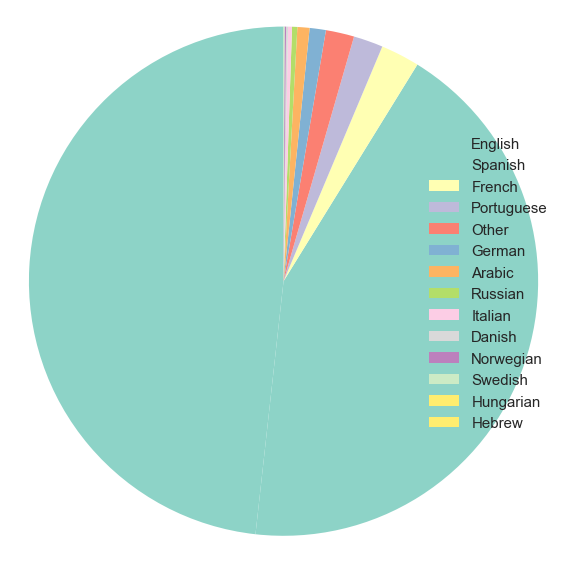

In [39]:
fig2, ax = plt.subplots(figsize=(8, 8))
patches, texts = plt.pie(language_sizes, colors=cm.Set3(np.linspace(0, 1, len(language_sizes))), startangle=90)
plt.legend(patches, language_labels, loc="right", fontsize=15)
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2.3 Tone Distribution

In this section, we analyze the average tone distribution for all source documents in the Mentions Table. Although the score ranges from -100 (extremely negative) to +100 (extremely positive), common values range between -10 to +10, with 0 indicating a neutral tone. The MentionDocTone field can be used to filter event "contexts" as an implicit measure of the importance of an event or as a proxy indicator for the impact of an event. For example, a riot event with slightly negative average tone is more likely to be a minor occurence compared to one with extremely negative average tone. However, it is important to note that the MentioDocTone indicator only provides a basic tonal assessment of an article. It is recommended that users interested in emotional measures use the Mentions and Global Knowledge Graph (GKG) tables to merge the complete 2,300 emotions and themes from the GKG Global Content Analysis Measures (GCAM) system into their analysis.

In [40]:
# Preprocessing: Mention Document Tone
tone = np.array(list(all_mentions.MentionDocTone))
print(all_mentions.MentionDocTone.describe())

count    116909.000000
mean    -0.860289     
std      3.701209     
min     -17.821782    
25%     -3.225806     
50%     -0.847458     
75%      1.636905     
max      23.333333    
Name: MentionDocTone, dtype: float64


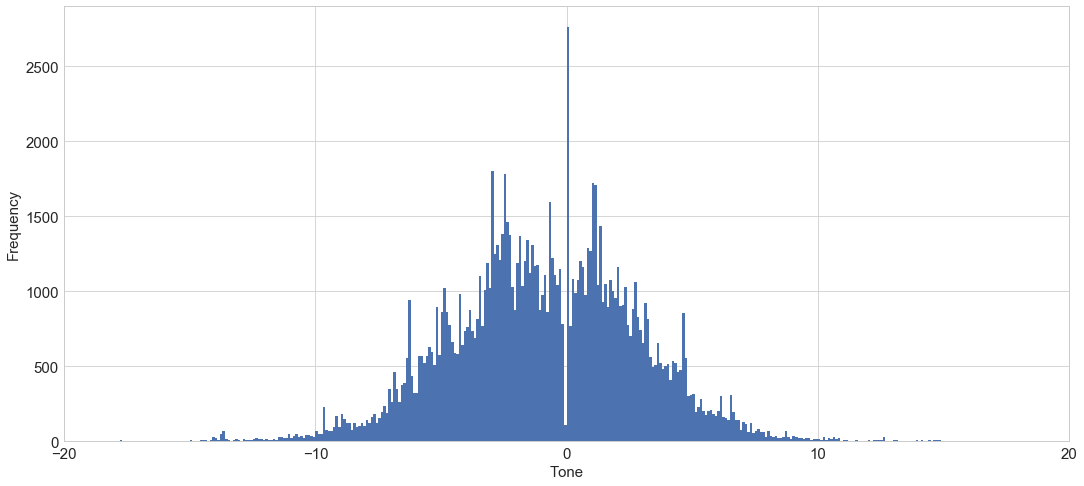

In [41]:
fig3, ax = plt.subplots(figsize=(18, 8))
ax.hist(tone, bins=500, range=(-20,30), histtype='bar', align='mid', orientation='vertical')
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_ylabel('Frequency' , fontsize=15)
ax.set_xlabel('Tone', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(np.arange(-20, 50, 10))
plt.xlim([-20,20])
plt.show()

## 2.4 Confidence Distribution

The Confidence indicator measures the percent confidence in the extraction of an event from an article for each mention.  See the discussion in the codebook at http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf. The Confidence measure is a new feature in GDELT 2.0 that makes it possible to adjust the sensitivity of GDELT towards specific use cases. Those wishing to find the earliest glimmers of breaking events or reports of very small-bore events that tend to only appear as part of period “round up” reports, can use the entire event stream, while those wishing to find only the largest
events with strongly detailed descriptions, can filter the Event stream to find only those events with the highest Confidence measures. The Confidence measure also makes it possible to identify the “best” news report to return for a given event (filtering all mentions of an event for those with the highest Confidence scores, most prominent positioning within the article, and/or in a specific source language – such as Arabic coverage of a protest versus English coverage of that protest)

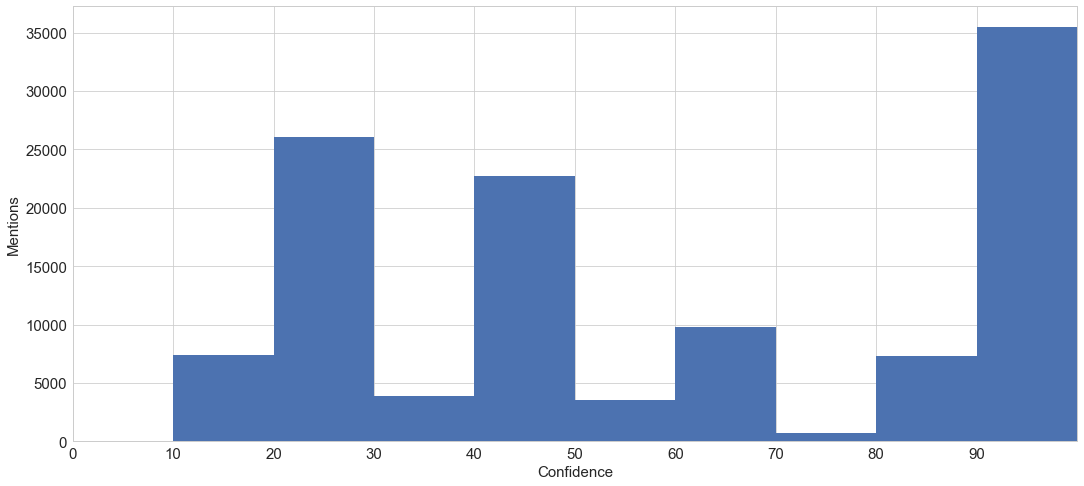

In [42]:
fig4, ax = plt.subplots(figsize=(18, 8))
plt.style.use('seaborn-paper')
values = list(all_mentions.Confidence)
plt.hist(values, bins=10, range=(0,100), histtype='bar', align='mid', orientation='vertical')
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_ylabel('Mentions' , fontsize=15)
ax.set_xlabel('Confidence', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xticks(np.arange(0, 100, 10))
plt.xlim([0,100])
plt.show()

## 2.5 Dominant Sources

In [43]:
# Pre-processing: Mention Source Names
clean_names = []

for sourcename in all_mentions.MentionSourceName:
    try:
        clean_names.append(re.search('(.*?)\.', sourcename).group(1))
    except:
        clean_names.append('nan')
        
all_mentions['SourceName'] = clean_names
MentionSourceNames = Counter(clean_names).most_common(50)
print(MentionSourceNames)
mention_source_name_labels = [MentionSourceNames[i][0] for i in range(len(MentionSourceNames))]
mention_source_name_values = [MentionSourceNames[i][1] for i in range(len(MentionSourceNames))]
ind = np.arange(len(mention_source_name_values)) 
width = 0.5

[('terra', 5390), ('noticias', 1680), ('contacto-latino', 1642), ('entornointeligente', 1450), ('ap', 1337), ('yahoo', 1229), ('caracol', 914), ('ntn24', 762), ('telesurtv', 729), ('eluniversal', 715), ('reuters', 701), ('vanguardia', 699), ('elpais', 672), ('eltiempo', 653), ('elespectador', 593), ('aguasdigital', 567), ('colombiareports', 532), ('telecinco', 507), ('prensa-latina', 495), ('elcomercio', 470), ('elheraldo', 434), ('oem', 426), ('wlox', 425), ('hawaiinewsnow', 415), ('rcnradio', 399), ('efe', 395), ('wradio', 390), ('radiosantafe', 387), ('informativo', 383), ('xinhuanet', 376), ('dailymail', 374), ('lainformacion', 368), ('kswo', 368), ('panampost', 366), ('foxnews', 366), ('ksby', 364), ('worldbulletin', 348), ('wn', 343), ('uol', 337), ('wandtv', 335), ('notimerica', 334), ('bbc', 328), ('wboc', 326), ('publimetro', 322), ('minuto30', 320), ('wect', 308), ('dw', 295), ('sputniknews', 295), ('lanacion', 284), ('el-carabobeno', 281)]


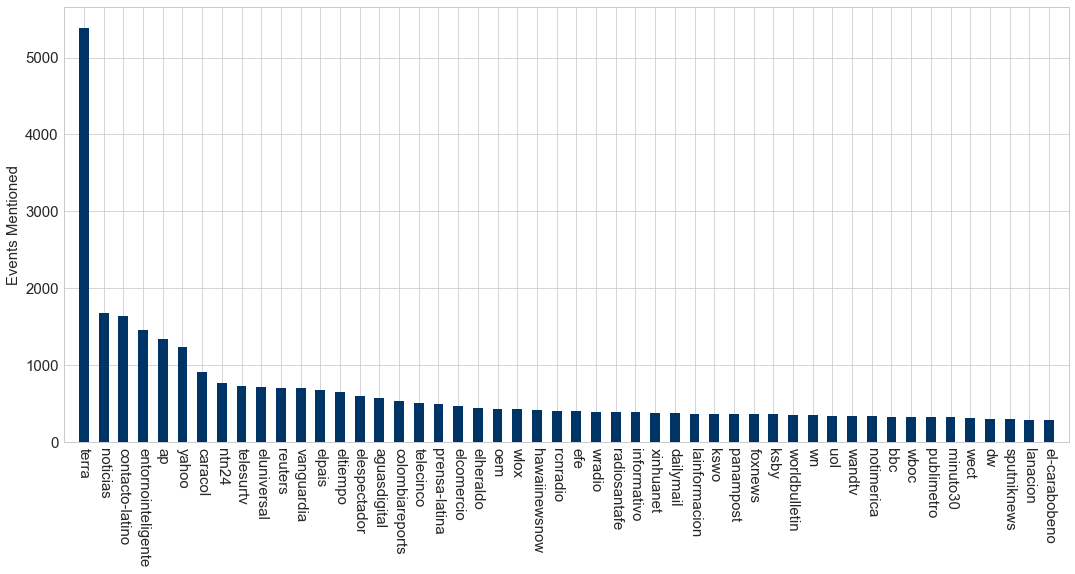

In [44]:
fig5, ax = plt.subplots(figsize=(18, 8))
ax.set_title('', fontsize=15, fontweight='bold')
ax.set_ylabel('Events Mentioned' , fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.bar(ind, mention_source_name_values, width, color='#003366')
ax.set_xticks(np.arange(0, len(mention_source_name_labels), 1))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=270)
plt.xlim([0,len(mention_source_name_labels)])
ax.set_xticklabels(mention_source_name_labels[::1])
plt.xlim([-1,50])
plt.show()

# 3.0 Source Filtering

## 3.1 Languages Comparison

In [45]:
names = ['Associated Press', 'Caracol', 'Reports', 'El Comercio', 'El Espectador', 'El Pais', 'El Tiempo', 'El Universal', 'Noticias', 'Vanguardia']
print('Associated Press: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'ap'].Language))
print('Caracol: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'caracol'].Language))
print('Reports: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'colombiareports'].Language))
print('El Comercio: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'elcomercio'].Language))
print('El Espectado: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'elespectador'].Language))
print('El Pais: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'elpais'].Language))
print('El Tiempo: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'eltiempo'].Language))
print('El Universal: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'eluniversal'].Language))
print('Noticias: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'noticias'].Language))
print('Vanguardia: ', Counter(all_mentions.loc[all_mentions['SourceName'] == 'vanguardia'].Language))

Associated Press:  Counter({'English': 1337})
Caracol:  Counter({'Spanish': 914})
Reports:  Counter({'English': 532})
El Comercio:  Counter({'Spanish': 470})
El Espectado:  Counter({'Spanish': 593})
El Pais:  Counter({'Spanish': 618, 'English': 54})
El Tiempo:  Counter({'Spanish': 643, 'English': 10})
El Universal:  Counter({'Spanish': 714, 'English': 1})
Noticias:  Counter({'Spanish': 1680})
Vanguardia:  Counter({'Spanish': 699})


## 3.2 Tone Comparison

In [46]:
def compare_sources(compare_by):
    ap = list(all_mentions.loc[all_mentions['SourceName'] == 'ap'][compare_by])
    caracol = list(all_mentions.loc[all_mentions['SourceName'] == 'caracol'][compare_by])
    colombiareports = list(all_mentions.loc[all_mentions['SourceName'] == 'colombiareports'][compare_by])
    elcomercio = list(all_mentions.loc[all_mentions['SourceName'] == 'elcomercio'][compare_by])
    elespectador = list(all_mentions.loc[all_mentions['SourceName'] == 'elespectador'][compare_by])
    elpais = list(all_mentions.loc[all_mentions['SourceName'] == 'elpais'][compare_by])
    eltiempo = list(all_mentions.loc[all_mentions['SourceName'] == 'eltiempo'][compare_by])
    eluniversal = list(all_mentions.loc[all_mentions['SourceName'] == 'eluniversal'][compare_by])
    noticias = list(all_mentions.loc[all_mentions['SourceName'] == 'noticias'][compare_by])
    vanguardia = list(all_mentions.loc[all_mentions['SourceName'] == 'vanguardia'][compare_by])

    myList = [ap] + [caracol] + [colombiareports] + [elcomercio] + [elespectador] + [elpais] + [eltiempo] + [eluniversal] + [noticias] + [vanguardia]

    return myList

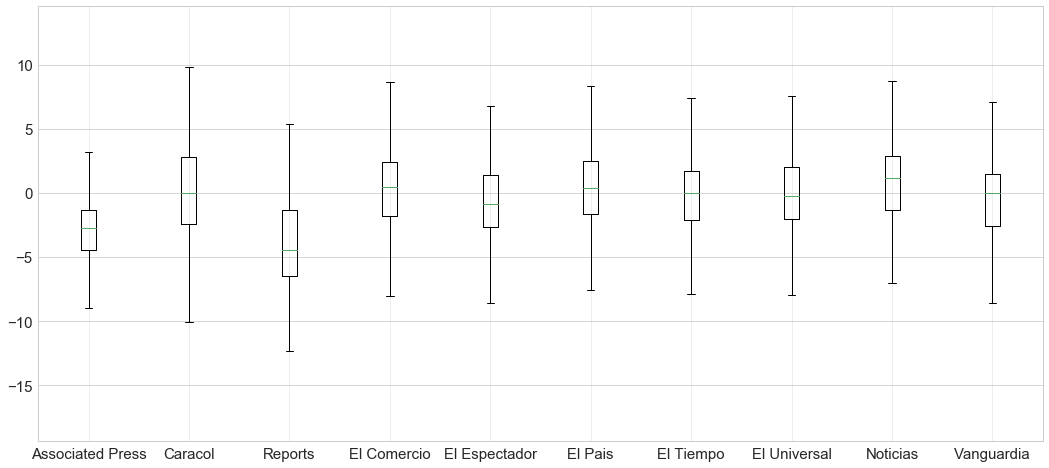

In [47]:
fig6, ax = plt.subplots(figsize=(18, 8), sharex=True)
ax.set_title('', fontsize=15, fontweight='bold')
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
myList = compare_sources('MentionDocTone')
for i,l in enumerate(myList):
    ax.boxplot(l, vert=True, positions = [i])
ax.set_xticks(range(len(myList)))
ax.set_xticklabels(names)
ax.set_xlim(-0.5, len(myList)-0.5)
plt.show()

## 3.3 Confidence Comparison

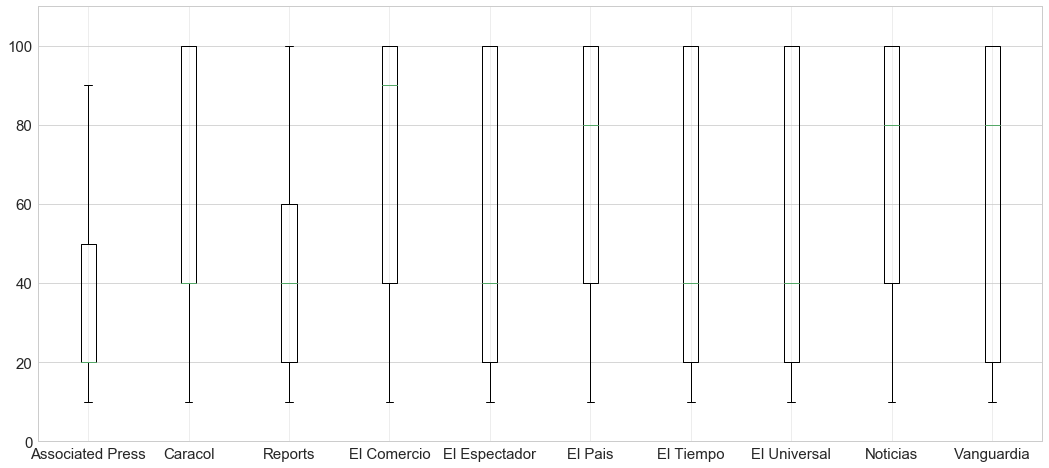

In [48]:
fig7, ax = plt.subplots(figsize=(18, 8), sharex=True)
ax.set_title('', fontsize=15, fontweight='bold')
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
myList = compare_sources('Confidence')
for i,l in enumerate(myList):
    ax.boxplot(l, vert=True, positions = [i])
ax.set_xticks(range(len(myList)))
ax.set_xticklabels(names)
ax.set_xlim(-0.5, len(myList)-0.5)
ax.set_ylim(0, 110)
plt.show()